In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

#### compute accuracy for different sets of trials
Easy = furthest from bound

Medium = second furthest, but still in main grid

Hard = closest, not in main grid.


In [13]:
n_tasks = 4

conf_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        for ii in [0,1]:

            categ_actual = l['categ_task%d'%(ii+1)]
            coord_actual = pt_labs[:,ii].round(2)
           
            # hard trials are closest to bound (variable grid)
            # easy is the furthest from bound
            # medium is second furthest
            dist_from_center = l['dist_from_bound%d'%(ii+1)].round(2)
            is_hard = dist_from_center<0.8
            is_easy = (dist_from_center==2.4) & is_main_grid
            is_medium = (dist_from_center==0.8) & is_main_grid
            
            correct = np.array(l['subject_correct'])
            # print(np.mean(correct))
            
            # print([ti,ii])
            # print(np.sum(is_hard), np.sum(is_medium), np.sum(is_easy))
            
            for ri in range(n_rois):

                pred = dec_withintask['preds_all'][si][ri][ti].astype(int)
                
                # binarize the predictions of 16-way classifier into 2 categories
                # based on current axis "ii"
                coords_pred = grid_pts[pred]
                coord_pred = coords_pred[:,ii]
                categ_pred = grid_utils.get_categ(coords_pred, ii+1)
                
                prob = dec_withintask['probs_all'][si][ri][ti]
                
                # "confidence" in assignment to category 2 vs 1
                # group the 16 points into categories w/r/t relevant axis
                g1 = grid_utils.get_categ(grid_pts, ii+1)==1
                p_categ1 = np.sum(prob[:,g1], axis=1)
                g2 = grid_utils.get_categ(grid_pts, ii+1)==2
                p_categ2 = np.sum(prob[:,g2], axis=1)
                
                # signed confidence will be: p(correct) - p(incorrect)
                signedconf = np.zeros_like(p_categ1)
                signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]
                
                
                inds = is_main_grid & correct
                
                conf_allmaintrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime_allmaintrials[si,ri,ti,ii] = d;
                
                acc_allmaintrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # easy trials
                inds = is_easy & correct
                                                          
                conf_easytrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime_easytrials[si,ri,ti,ii] = d;
                
                acc_easytrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # medium trials
                inds = is_medium & correct
                                                       
                conf_medtrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime_medtrials[si,ri,ti,ii] = d;
                
                acc_medtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                

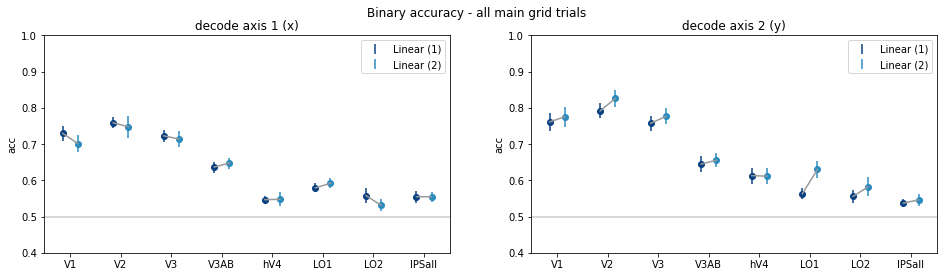

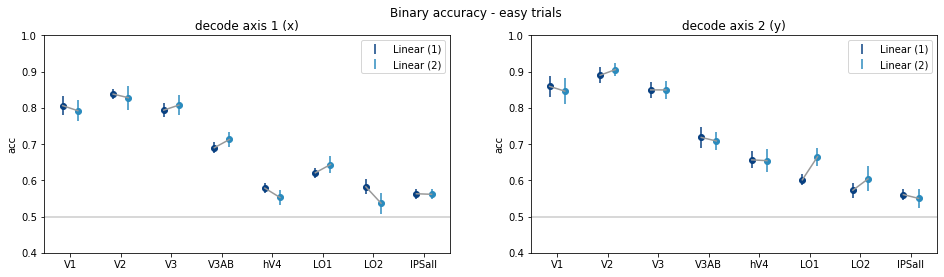

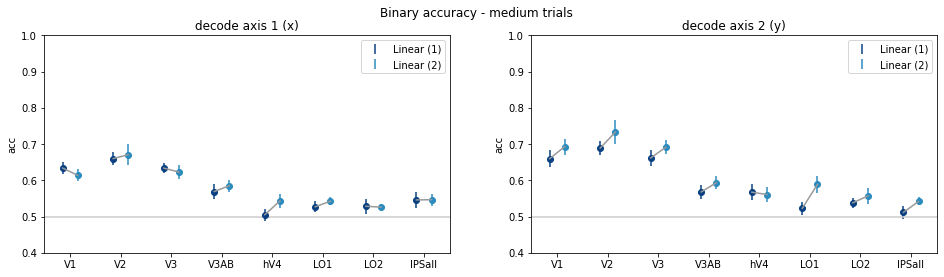

In [14]:
ti_plot = [0,1]

x_jitter = [-0.15, 0.15]

for avals, name in zip([acc_allmaintrials, acc_easytrials, acc_medtrials], \
                     ['all main grid trials', 'easy trials','medium trials']):    
    plt.figure(figsize=(16,4))

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        plt.subplot(1,2,ii+1)

        plt.axhline(0.5, color=[0.8, 0.8, 0.8])

        lh = []

        for ti in ti_plot:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = avals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)
            
        for ri in range(n_rois):
            
            meanvals = np.mean(avals[:,ri,ti_plot,ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6])

        plt.ylim([0.4, 1])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('acc')

        plt.legend(lh,np.array(task_names)[ti_plot])

        plt.title('decode %s'%axis_name)

    plt.suptitle('Binary accuracy - %s'%name)


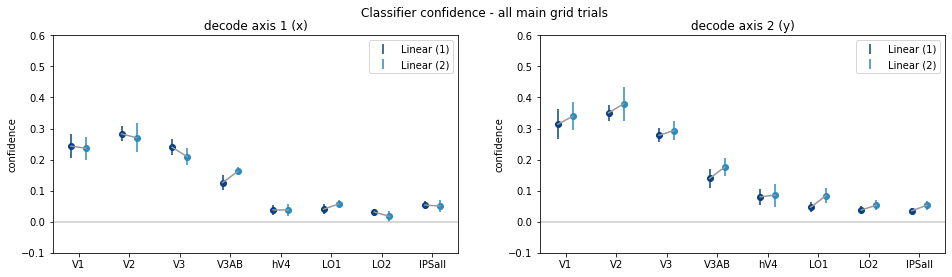

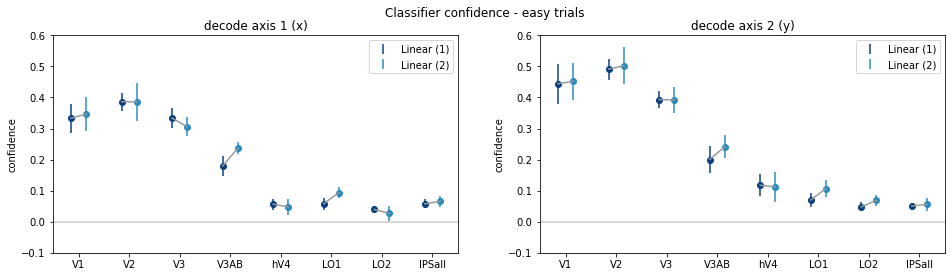

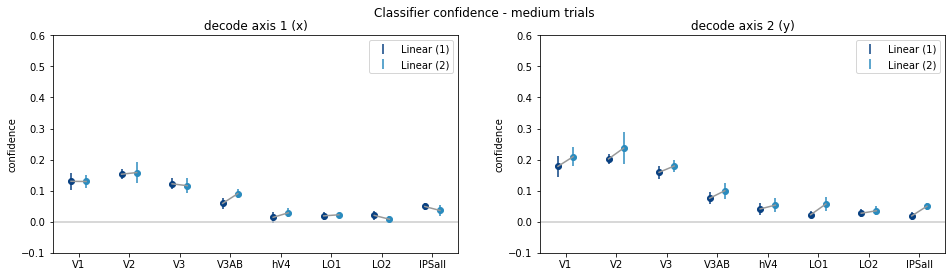

In [11]:
ti_plot = [0,1]

x_jitter = [-0.15, 0.15]

for rvals, name in zip([conf_allmaintrials, conf_easytrials, conf_medtrials], \
                     ['all main grid trials', 'easy trials','medium trials']):    
    plt.figure(figsize=(16,4))

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        plt.subplot(1,2,ii+1)

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for ti in ti_plot:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = rvals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)
            
        for ri in range(n_rois):
            
            meanvals = np.mean(rvals[:,ri,ti_plot,ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6])

        plt.ylim([-0.1, 0.6])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('confidence')

        plt.legend(lh,np.array(task_names)[ti_plot])

        plt.title('decode %s'%axis_name)

    plt.suptitle('Classifier confidence - %s'%name)


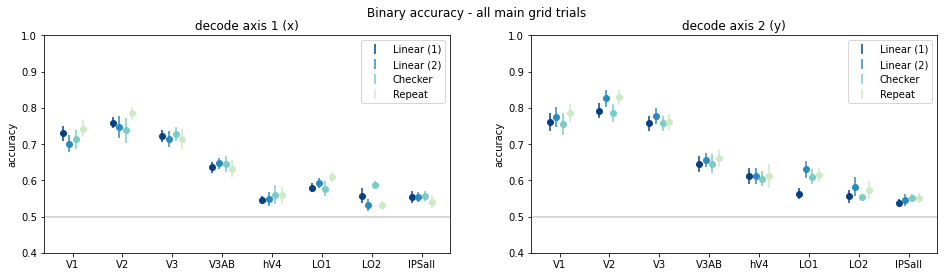

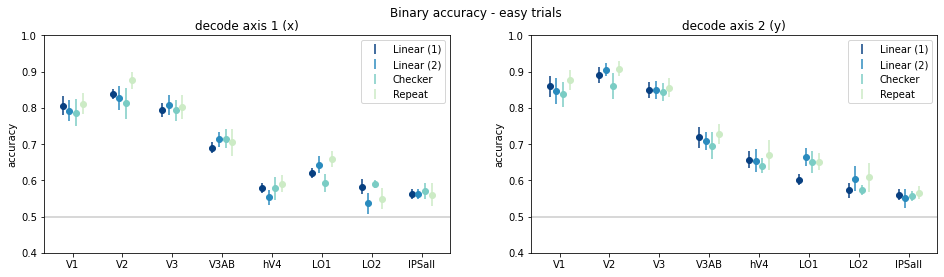

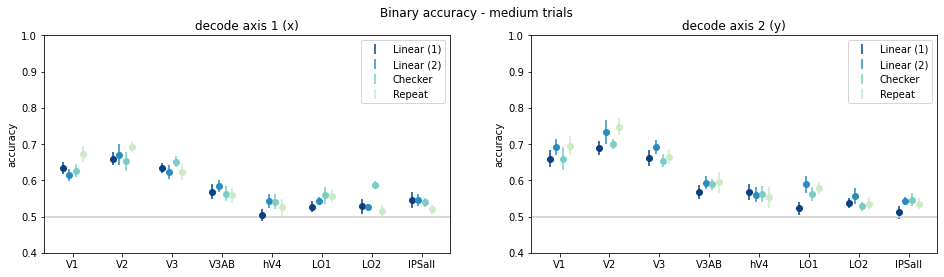

In [12]:
ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 4)

for avals, name in zip([acc_allmaintrials, acc_easytrials, acc_medtrials], \
                     ['all main grid trials', 'easy trials','medium trials']):
    
    plt.figure(figsize=(16,4))

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        plt.subplot(1,2,ii+1)

        plt.axhline(1/2, color=[0.8, 0.8, 0.8])

        lh = []

        for ti in ti_plot:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = avals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)
          
        plt.ylim([0.4, 1.0])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('accuracy')

        plt.legend(lh,np.array(task_names)[ti_plot])

        plt.title('decode %s'%axis_name)

    plt.suptitle('Binary accuracy - %s'%name)


#### compare classification acc on the hardest trials between tasks
need to use bootstrapping here because trial counts are not necc. the same between tasks

In [17]:
# n_dist_bins = 4
# dist_bin_edges = np.linspace(0, 0.8, n_dist_bins+1)

n_coord_bins = 6;
coord_bin_edges = np.linspace(2.5-0.8, 2.5+0.8, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = (center-bin_centers).round(2)

# n_boot_iter = 1000;
n_boot_iter = 2;

n_boot_samp = 100;

# bootstrap the distribution of classifier accuracy on hard trials, 
# for each linear axis and two linear tasks.
dprime_hardtrials_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))
signedconf_hardtrials_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))

for si, ss in enumerate(subjects):

    print(si)
    
    # loop over two axes
    for ii in [0,1]:
        
        l = lab[ss]
        
        task_labs = l['task']
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        categ_actual = np.array(l['categ_task%d'%(ii+1)]).astype(int)
        
        # dist_actual = np.array(l['dist_from_bound%d'%(ii+1)])
        
        # using only the trials in center of grid
        # (hard for all the tasks)
        dist_from_center1 = l['dist_from_bound1']
        dist_from_center2 = l['dist_from_bound2']
        
        is_hard = (dist_from_center1<0.79) & (dist_from_center2<0.79)

        correct = np.array(l['subject_correct'])
        
        coord_actual = pt_labs[:,ii].round(2)
        
        # make rough bins that help equate stimulus distributions
        # across tasks when bootstrapping
        coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
            coord_binned[binds] = cb
        assert(np.all(coord_binned[is_hard]>-1))
        
        
        inds1 = np.where(is_hard & correct & (task_labs==1))[0]
        inds2 = np.where(is_hard & correct & (task_labs==2))[0]

        
        # now figure out which bins we can use and still have everything balanced in both tasks
        un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
        un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

#         print(un1, counts1)
#         print(un2, counts2)
    
#         print(bin_dist[un1], bin_dist[un2])

        bins_balance = []
        for uu in np.union1d(un1, un2):
            d = bin_dist[uu]
            in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
            in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
            if in1 and in2:
                bins_balance += [uu]
                
        print(bin_dist[bins_balance])
        
        # checking that the bins we are using represent each category equally
        assert(np.mean(bin_dist[bins_balance]<0)==0.5)
        
        n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))

        
        is_hard_all = is_hard
        correct_all = correct
        coord_all = coord_actual
        coord_binned_all = coord_binned
        categ_actual_all = categ_actual
        # dist_actual_all = dist_actual
        
        
        for ti,tt in enumerate([1,2]):
            
            is_hard = is_hard_all[task_labs==tt]
            correct = correct_all[task_labs==tt]
            coord_binned = coord_binned_all[task_labs==tt]
            # dist_actual = dist_actual_all[task_labs==tt]
            categ_actual = categ_actual_all[task_labs==tt]
            coord_actual = coord_all[task_labs==tt]
            
            # inds = np.where(is_hard)[0]
            inds = np.where(is_hard & correct)[0]
            
            for bi in range(n_boot_iter):

                # make a resampling order that represents each bin equally
                inds_resamp = []
                for bn in bins_balance:
                    inds_bin = inds[coord_binned[inds]==bn]
                    assert(len(inds_bin)>0)
                    if bi==0:
                        print(len(inds_bin), n_samp_eachbin)
                    # if bi==0:
                        # print(len(inds_bin), n_samp_eachbin)
                    inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
                inds_resamp = np.concatenate(inds_resamp, axis=0)
               
                # check that the set we created has half each category
                assert(np.mean(categ_actual[inds_resamp]==1)==0.5)
                
#                 print(np.unique(coord_actual[inds_resamp], return_counts=True))
                      
                # double check resample order
                assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
                counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
                assert(np.all(counts==n_samp_eachbin))
                
                for ri in range(n_rois):

                    pred = dec_withintask['preds_all'][si][ri][ti].astype(int)

                    categ_pred = grid_utils.get_categ(grid_pts[pred,:], ii+1)

                    prob = dec_withintask['probs_all'][si][ri][ti]

                    # "confidence" in assignment to category 2 vs 1
                    # group the 16 points into categories w/r/t relevant axis
                    g1 = grid_utils.get_categ(grid_pts, ii+1)==1
                    p_categ1 = np.sum(prob[:,g1], axis=1)
                    g2 = grid_utils.get_categ(grid_pts, ii+1)==2
                    p_categ2 = np.sum(prob[:,g2], axis=1)

                    pdiff = p_categ2 - p_categ1
                    
                    signedconf = np.zeros_like(pdiff)
                    signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                    signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]
                    
                    
                    d = stats_utils.get_dprime(categ_pred[inds_resamp], categ_actual[inds_resamp])
                    dprime_hardtrials_boot[si,ri,ti,ii,bi] = d;
                    
                    signedconf_hardtrials_boot[si,ri,ti,ii,bi] = np.mean(signedconf[inds_resamp])

0
[ 0.4   0.13 -0.13 -0.4 ]
14 25
10 25
8 25
5 25
6 25
6 25
5 25
6 25
[ 0.4   0.13 -0.13 -0.4 ]
8 25
5 25
7 25
3 25
2 25
10 25
17 25
4 25
1
[ 0.4   0.13 -0.13 -0.4 ]
1 25
2 25
10 25
17 25
4 25
4 25
8 25
4 25
[ 0.4   0.13 -0.13 -0.4 ]
8 25
4 25
4 25
5 25
6 25
1 25
7 25
18 25
2
[ 0.4   0.13 -0.13 -0.4 ]
8 25
6 25
6 25
16 25
4 25
7 25
8 25
5 25
[ 0.4   0.13 -0.13 -0.4 ]
9 25
3 25
5 25
7 25
8 25
9 25
11 25
7 25
3
[ 0.4 -0.4]
15 50
14 50
12 50
8 50
[ 0.4 -0.4]
6 50
2 50
21 50
21 50
4
[ 0.4 -0.4]
10 50
19 50
7 50
2 50
[ 0.4   0.13 -0.13 -0.4 ]
7 25
2 25
7 25
4 25
7 25
1 25
9 25
11 25
5
[ 0.4 -0.4]
1 50
9 50
4 50
4 50
[ 0.4   0.13 -0.13 -0.4 ]
4 25
2 25
2 25
2 25
5 25
1 25
2 25
14 25
6
[ 0.4 -0.4]
7 50
15 50
8 50
7 50
[ 0.4 -0.4]
4 50
5 50
14 50
31 50


Text(0.5, 0.98, 'Centermost trials, classifier confidence, median +/- bootstrapped 95 CI')

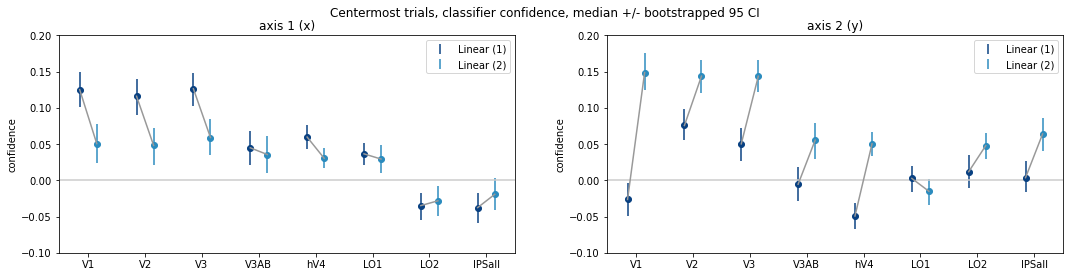

In [13]:
x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(18,4))

for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    
    plt.subplot(1,2,ii+1)
    
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    mtmp = []
    for ti, boot_vals in enumerate([signedconf_hardtrials_boot[:,:,0,ii,:], \
                                    signedconf_hardtrials_boot[:,:,1,ii,:]]):
        
        x_ticks = np.arange(n_rois) + x_jitter[ti]
    
        # average over subjects (within each bootstrapping iteration)
        boot_vals_avg = np.mean(boot_vals, axis=0)
        boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)
           
        # get percentiles of the bootstrapped distrib
        median_vals = boot_pct[1]
        mtmp.append(median_vals)
        lower_vals = median_vals - boot_pct[0]
        upper_vals = boot_pct[2] - median_vals
        
        plt.plot(x_ticks, median_vals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        median_vals = [mtmp[0][ri], mtmp[1][ri]]
        plt.plot(ri+x_jitter, median_vals,'-',color=[0.6, 0.6, 0.6])

    plt.ylim([-0.1, 0.2])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,task_names[0:2])
    
    plt.title(axis_name)
    
plt.suptitle('Centermost trials, classifier confidence, median +/- bootstrapped 95 CI')


In [19]:
# n_dist_bins = 4
# dist_bin_edges = np.linspace(0, 0.8, n_dist_bins+1)

n_coord_bins = 6;
coord_bin_edges = np.linspace(2.5-0.8, 2.5+0.8, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = (center-bin_centers).round(2)

n_boot_iter = 1000;
# n_boot_iter = 2;

n_boot_samp = 100;

# bootstrap the distribution of classifier accuracy on hard trials, 
# for each linear axis and two linear tasks.
dprime_hardtrials_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))
signedconf_hardtrials_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))

for si, ss in enumerate(subjects):

    print(si)
    
    # loop over two axes
    for ii in [0,1]:
        
        l = lab[ss]
        
        task_labs = l['task']
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        categ_actual = np.array(l['categ_task%d'%(ii+1)]).astype(int)
        
        # dist_actual = np.array(l['dist_from_bound%d'%(ii+1)])
        
        # using only the trials in center of grid
        # (hard for all the tasks)
        dist_from_center1 = l['dist_from_bound1']
        dist_from_center2 = l['dist_from_bound2']
        
        is_hard = (dist_from_center1<0.79) & (dist_from_center2<0.79)

        # correct = np.array(l['subject_correct'])
        
        coord_actual = pt_labs[:,ii].round(2)
        
        # make rough bins that help equate stimulus distributions
        # across tasks when bootstrapping
        coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
            coord_binned[binds] = cb
        assert(np.all(coord_binned[is_hard]>-1))
        
        
        inds1 = np.where(is_hard & (task_labs==1))[0]
        inds2 = np.where(is_hard & (task_labs==2))[0]

        
        # now figure out which bins we can use and still have everything balanced in both tasks
        un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
        un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

#         print(un1, counts1)
#         print(un2, counts2)
    
#         print(bin_dist[un1], bin_dist[un2])

        bins_balance = []
        for uu in np.union1d(un1, un2):
            d = bin_dist[uu]
            in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
            in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
            if in1 and in2:
                bins_balance += [uu]
                
        print(bin_dist[bins_balance])
        
        # checking that the bins we are using represent each category equally
        assert(np.mean(bin_dist[bins_balance]<0)==0.5)
        
        n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))

        
        is_hard_all = is_hard
        # correct_all = correct
        coord_all = coord_actual
        coord_binned_all = coord_binned
        categ_actual_all = categ_actual
        # dist_actual_all = dist_actual
        
        
        for ti,tt in enumerate([1,2]):
            
            is_hard = is_hard_all[task_labs==tt]
            # correct = correct_all[task_labs==tt]
            coord_binned = coord_binned_all[task_labs==tt]
            # dist_actual = dist_actual_all[task_labs==tt]
            categ_actual = categ_actual_all[task_labs==tt]
            coord_actual = coord_all[task_labs==tt]
            
            inds = np.where(is_hard)[0]
            # inds = np.where(is_hard & correct)[0]
            
            for bi in range(n_boot_iter):

                # make a resampling order that represents each bin equally
                inds_resamp = []
                for bn in bins_balance:
                    inds_bin = inds[coord_binned[inds]==bn]
                    assert(len(inds_bin)>0)
                    if bi==0:
                        print(len(inds_bin), n_samp_eachbin)
                    # if bi==0:
                        # print(len(inds_bin), n_samp_eachbin)
                    inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
                inds_resamp = np.concatenate(inds_resamp, axis=0)
               
                # check that the set we created has half each category
                assert(np.mean(categ_actual[inds_resamp]==1)==0.5)
                
#                 print(np.unique(coord_actual[inds_resamp], return_counts=True))
                      
                # double check resample order
                assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
                counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
                assert(np.all(counts==n_samp_eachbin))
                
                for ri in range(n_rois):

                    pred = dec_withintask['preds_all'][si][ri][ti].astype(int)

                    categ_pred = grid_utils.get_categ(grid_pts[pred,:], ii+1)

                    prob = dec_withintask['probs_all'][si][ri][ti]

                    # "confidence" in assignment to category 2 vs 1
                    # group the 16 points into categories w/r/t relevant axis
                    g1 = grid_utils.get_categ(grid_pts, ii+1)==1
                    p_categ1 = np.sum(prob[:,g1], axis=1)
                    g2 = grid_utils.get_categ(grid_pts, ii+1)==2
                    p_categ2 = np.sum(prob[:,g2], axis=1)

                    pdiff = p_categ2 - p_categ1
                    
                    signedconf = np.zeros_like(pdiff)
                    signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                    signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]
                    
                    
                    d = stats_utils.get_dprime(categ_pred[inds_resamp], categ_actual[inds_resamp])
                    dprime_hardtrials_boot[si,ri,ti,ii,bi] = d;
                    
                    signedconf_hardtrials_boot[si,ri,ti,ii,bi] = np.mean(signedconf[inds_resamp])

0
[ 0.4   0.13 -0.13 -0.4 ]
16 25
20 25
16 25
7 25
6 25
12 25
8 25
12 25
[ 0.4   0.13 -0.13 -0.4 ]
12 25
8 25
11 25
10 25
6 25
22 25
27 25
4 25
1
[ 0.4   0.13 -0.13 -0.4 ]
11 25
11 25
10 25
17 25
13 25
7 25
10 25
9 25
[ 0.4   0.13 -0.13 -0.4 ]
13 25
8 25
5 25
10 25
22 25
11 25
7 25
18 25
2
[ 0.4   0.13 -0.13 -0.4 ]
21 25
10 25
9 25
21 25
6 25
10 25
12 25
7 25
[ 0.4   0.13 -0.13 -0.4 ]
12 25
4 25
11 25
14 25
18 25
15 25
12 25
8 25
3
[ 0.4 -0.4]
28 50
27 50
14 50
12 50
[ 0.4 -0.4]
12 50
10 50
29 50
27 50
4
[ 0.4 -0.4]
15 50
27 50
10 50
6 50
[ 0.4   0.13 -0.13 -0.4 ]
10 25
3 25
9 25
5 25
13 25
16 25
10 25
11 25
5
[ 0.4   0.13 -0.13 -0.4 ]
16 25
5 25
3 25
14 25
9 25
6 25
6 25
10 25
[ 0.4   0.13 -0.13 -0.4 ]
12 25
3 25
5 25
6 25
20 25
5 25
3 25
17 25
6
[ 0.4 -0.4]
36 50
20 50
10 50
11 50
[ 0.4 -0.4]
9 50
16 50
27 50
34 50


Text(0.5, 0.98, 'Centermost trials, classifier confidence, median +/- bootstrapped 95 CI')

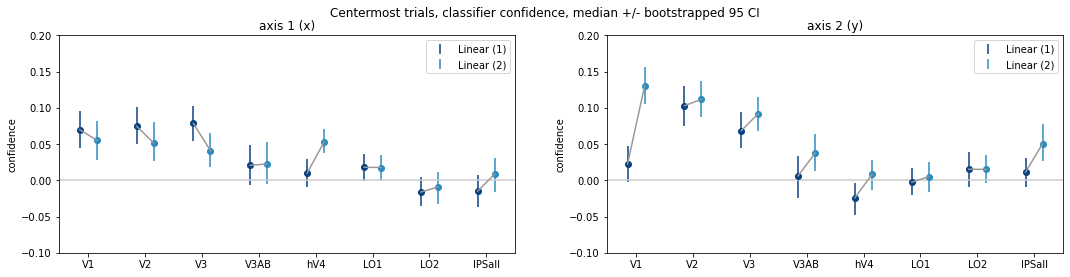

In [20]:
x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(18,4))

for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    
    plt.subplot(1,2,ii+1)
    
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    mtmp = []
    for ti, boot_vals in enumerate([signedconf_hardtrials_boot[:,:,0,ii,:], \
                                    signedconf_hardtrials_boot[:,:,1,ii,:]]):
        
        x_ticks = np.arange(n_rois) + x_jitter[ti]
    
        # average over subjects (within each bootstrapping iteration)
        boot_vals_avg = np.mean(boot_vals, axis=0)
        boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)
           
        # get percentiles of the bootstrapped distrib
        median_vals = boot_pct[1]
        mtmp.append(median_vals)
        lower_vals = median_vals - boot_pct[0]
        upper_vals = boot_pct[2] - median_vals
        
        plt.plot(x_ticks, median_vals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        median_vals = [mtmp[0][ri], mtmp[1][ri]]
        plt.plot(ri+x_jitter, median_vals,'-',color=[0.6, 0.6, 0.6])

    plt.ylim([-0.1, 0.2])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,task_names[0:2])
    
    plt.title(axis_name)
    
plt.suptitle('Centermost trials, classifier confidence, median +/- bootstrapped 95 CI')
